## 현재날씨 : 지역, 상태, 온도, 체감온도, 습도, 풍향

In [24]:
import requests
from bs4 import BeautifulSoup
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
 
source = requests.get('https://www.weather.go.kr/weather/observation/currentweather.jsp')
soup = BeautifulSoup(source.content,"html.parser")
 
table = soup.find('table',{'class':'table_develop3'})
data = []
 
print("#"*50)

for tr in table.find_all('tr'):
    tds = list(tr.find_all('td'))
    for td in tds:
        if td.find('a'):
            point = td.find('a').text
            status = tds[1].text
            temp = tds[5].text
            body_temp = tds[7].text
            humidity = tds[10].text
            wind = tds[11].text
            print("{0:<7} {1:<7} {2:<7} {3:<7} {4:<7} {5:<7} ".format(point,status,temp,body_temp, humidity, wind))
            data.append([point,status,temp,body_temp, humidity, wind])
            
print("#"*50)
 
print(data)

##################################################
강릉              5.2     5.2     27      남동      
강진군             2.0     -0.1    52      북서      
강화              -4.2    -6.9    77      남       
거제              1.5     1.5     42      북       
거창              1.7     -1.6    34      북북서     
경주시             1.3     -2.8    25      서북서     
고산              5.2     -1.0    76      북북서     
고창              0.1     0.1     56      정온      
고창군             0.6     0.6     55      정온      
고흥              3.1     -0.9    41      북북서     
광양시             3.7     0.2     34      서북서     
광주              2.8     1.0     47      서남서     
구미              1.1     -2.7    37      서북서     
군산              1.0     1.0     56      남서      
금산              1.4     -0.3    46      서북서     
김해시             1.1     -3.4    27      서북서     
남원              1.6     -0.5    44      서북서     
남해              2.0     0.5     42      북북동     
대관령             -5.4    -13.1   49      서북서     
대구      맑음      0.

In [25]:
with open('weather.csv','w', encoding='utf-8-sig') as f:
    f.write('지역, 상태, 온도, 체감온도, 습도, 풍향\n')
    for i in data:
        f.write('{0},{1},{2},{3},{4},{5}\n'.format(i[0],i[1],i[2],i[3],i[4],i[5]))

In [32]:
df = pandas.read_csv('weather.csv', index_col='지역' , encoding='utf-8-sig')

#### 여기 안 함

In [33]:
city_df = df.loc[['서울','인천','대전','대구','광주','부산','울산']]

print(city_df)

city_df.to_csv('현재날씨.csv',encoding='utf-8-sig')

    상태   온도   체감온도   습도   풍향
지역                          
서울     -4.2   -6.9   48   남서
인천     -4.4   -9.1   69  남남동
대전      1.1   -1.2   38  남남동
대구  맑음  0.8   -4.8   37  서북서
광주      2.8    1.0   47  서남서
부산      1.4   -3.6   31  서북서
울산      1.2   -3.3   22  서북서


C:\Users\smhrd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\smhrd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


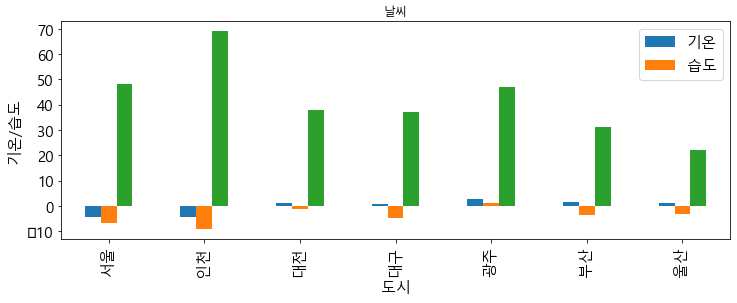

In [34]:
# 그래프
font_name = mpl.font_manager.FontProperties(fname='C:\Windows\Fonts\malgun.ttf').get_name()
mpl.rc('font',family=font_name)
 
ax = city_df.plot(kind='bar',title='날씨',figsize=(12,4),legend=True,fontsize=15)
ax.set_xlabel('도시',fontsize=15)
ax.set_ylabel('기온/습도',fontsize=15)
ax.legend(['기온','습도'],fontsize=15)
 
plt.show()

#### 여기부터

### DB 연결

In [28]:
!pip install cx_Oracle
import cx_Oracle
from bs4 import BeautifulSoup
import requests as req
from pprint import pprint
!pip install pymssql
import pyodbc

### Oracle DB : data 생성

In [35]:
dsn = cx_Oracle.makedsn('project-db-stu.ddns.net',1524,'xe')
url = "https://www.weather.go.kr/weather/observation/currentweather.jsp"
material = req.get(url)
soup = BeautifulSoup(material.text, 'html.parser')
conn = cx_Oracle.connect('cgi_8_1_1216','smhrd1',dsn)

with conn :
    cur = conn.cursor()
    drop_table = """
                    BEGIN
                        EXECUTE IMMEDIATE 'DROP TABLE forecast';
                    EXCEPTION
                        WHEN OTHERS THEN
                            IF SQLCODE != -942 THEN
                                RAISE;
                            END IF;
                    END;
                """
    cur.execute(drop_table)
    
    drop_seq = """
                    BEGIN
                        EXECUTE IMMEDIATE 'DROP SEQUENCE fc_seq';
                    EXCEPTION
                        WHEN OTHERS THEN
                        IF SQLCODE != -2289 THEN
                            RAISE;
                        END IF;
                    END;
                """
    cur.execute(drop_seq)
    
    create_table ="""
                    create table forecast(
                        city_index number(4) primary key,
                        city_name varchar2(20),
                        weather_stat varchar2(20),
                        temp number(5),
                        body_temp number(5),
                        hum number(5),
                        wind varchar2(20)                        
                    )
                """
    cur.execute(create_table)
    
    cur.execute("create sequence fc_seq")
        
    for tr in table.find_all('tr'):
        tds = list(tr.find_all('td'))
        for td in tds:
            if td.find('a'):
                point = td.find('a').text
                status = tds[1].text
                temp = tds[5].text
                body_temp = tds[7].text
                humidity = tds[10].text
                wind = tds[11].text
                print("{0:<7} {1:<7} {2:<7} {3:<7} {4:<7} {5:<7} ".format(point, status, temp, body_temp, humidity, wind))
                data.append([point, status, temp, body_temp, humidity, wind])
        
        # 데이터 삽입
        insert_data = """
                        insert into forecast(city_index, city_name, weather_stat, temp, body_temp, hum, wind)
                        values(fc_seq.nextval, :1, :2, :3, :4, :5, :6)
                    """
        cur.execute(insert_data, (point, status, temp, body_temp, humidity, wind))
    conn.commit()

    cur.execute("select * from forecast") #데이터 조회 => 데이터 추가됐는지 확인
    pprint(cur.fetchall())

강릉              5.2     5.2     27      남동      
강진군             2.0     -0.1    52      북서      
강화              -4.2    -6.9    77      남       
거제              1.5     1.5     42      북       
거창              1.7     -1.6    34      북북서     
경주시             1.3     -2.8    25      서북서     
고산              5.2     -1.0    76      북북서     
고창              0.1     0.1     56      정온      
고창군             0.6     0.6     55      정온      
고흥              3.1     -0.9    41      북북서     
광양시             3.7     0.2     34      서북서     
광주              2.8     1.0     47      서남서     
구미              1.1     -2.7    37      서북서     
군산              1.0     1.0     56      남서      
금산              1.4     -0.3    46      서북서     
김해시             1.1     -3.4    27      서북서     
남원              1.6     -0.5    44      서북서     
남해              2.0     0.5     42      북북동     
대관령             -5.4    -13.1   49      서북서     
대구      맑음      0.8     -4.8    37      서북서     
대전              1.1 